## <u> sso-freeze - Python </u>

The following code is a script that takes Gladstone's stop_hrci and translates it into python.
This code has been split up into the different section for each different functions carried out.

<i>End Goal </i>: To simply enter the OBSid -> gather the selected files -> apply ''sso_freeze'' -> output the corrected file
to a different text file

Sections are as follows:

*1)* Reading in the Chandra events file (uncorrected) and extraxt relevant header info </br>

*2)* Reading in the orbit empheris file and extract relevant header info </br>

*3)* Read in the ''chandra_horizons file'', extract relevant info and interpolate the data </br>

*4)* Apply the correction to allow the photons to be tracked to their position on Jupiter </br>

*5)* The new positions of the photons replace the uncorrected positions from the fits file and is written to a new fits file. </br>


#### <u><i> Hardwire locations </u></i> 

In the cells below, there are various hardwire locations that need to be inputted (hopefully once this code is properly optimised, there should be no need for this).

The hardwire locations are as follows:

*Section 1)*: <b>evt_location</b> -> enter path of the event file to be corrected

*Section 2)*: <b>orb_location</b> -> enter path of the orbit empheris file of the spacecraft

*Section 3)*: <b>eph_location</b> -> enter path of the chandra_horizons2000 file used (from folder of horizons2000 files)

*Section 5)*: <b>new_evt_location</b> -> enter path of the new corrected fits file to be written to

In [1]:
#Purpose: Read in Chandra event file and empheris files. Correct event file by time-tagging photons to their position
#on Jupiter. New fits file should produce a projection of the x-rays on Jupiter.
#Category: Chandra fits file correction (Jupiter)
#Authors: Dale Weigt (D.M.Weigt@soton.ac.uk), apadpted from Randy Gladstone's 'stop_hrci' IDL script

"""All the relevant packages are imported for code below"""

import numpy as np
import math
import pandas as pd
import scipy
from astropy.io import ascii
import matplotlib
from matplotlib import pyplot as plt
from numpy.random import poisson 
import time
from distutils.version import LooseVersion
import datetime
import calendar

import glob
import os
from astropy.io import fits as pyfits
from astropy.table import Table, Column
from astropy import units as u
from astropy.units import imperial
from astropy.convolution import convolve, Box1DKernel
from scipy import interpolate

"""Below are a list of defined functions used in the code below
----------------------------------------------------------------
(Look into providing help pages plus errors - look at Hull stuff)"""

def doy_frac(DOY, hour, minutes, seconds): # function takes a given DOY, hour, minutes, seconds...
    frac = DOY + hour/24.0 + minutes/1440.0 + seconds/86400.0 #... and calualtes the correct DOY fraction.
    return frac


# Setup the font used for plotting
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['xtick.labelsize']=14
matplotlib.rcParams['ytick.labelsize']=14
matplotlib.rcParams['agg.path.chunksize'] = 1000000
# AU to meter conversion - useful later on (probably a function built in already)
AU_2_m = 1.49598E+11

In [2]:
"""SECTION 1)"""
# The code below reads in the Chandra event file and extracts the relevant header info needed later

evt_location = r'C:\Users\dmw1n18\Documents\PhD\Chandra\Data\20002\primary\hrcf20002N002_evt2.fits' # path of .evt file to be 
#corrected

evt_file = pyfits.open(evt_location)
# event file is read in and opened to extract header info
evt_hdr = evt_file[1].header # event file header...
evt_data = evt_file[1].data #...and associated date with each header
evt_time = evt_data['TIME'] # time of each photon observred as it reaches detector(???)
start_time = evt_hdr['TSTART'] # start time of observation (in seconds)
start_date = evt_hdr['DATE-OBS'] # start date of observation
evt_x = evt_data['X'] # x position of target
evt_y = evt_data['Y'] # y position of target
#end_time = evt_hdr['TSTOP']
RA_0 = evt_hdr['RA_NOM'] # RA origin of target at the start of the observation
DEC_0 = evt_hdr['DEC_NOM'] # DEC origin of target at the start of the observation
evt_file.close()

evt_date = pd.to_datetime(start_date) # converts the date to a timestamp - to allow the time to be separated and used for
# calculation of the DOY and DOYFRAC
evt_hour = evt_date.hour # hour of observation
evt_doy = evt_date.strftime('%j') # doy of observation
evt_mins = evt_date.minute # minute of observation
evt_secs = evt_date.second # second of observation
evt_DOYFRAC = doy_frac(float(evt_doy), float(evt_hour), float(evt_mins), float(evt_secs)) # calculating the DOYFRAC
chand_time = (evt_time - start_time)/86400.0 # calculating time cadence of chandra...
doy_chandra = chand_time + evt_DOYFRAC #... to calculate the DOY of chandra


In [3]:
"""SECTION 2)"""
# The code below reads in the orbit empheris file for the identified OBSid

orb_location = r'C:\Users\dmw1n18\Documents\PhD\Chandra\Data\20002\primary\orbitf617803505N001_eph1.fits' # path of orbit empheris 
# file used corresponding to the event file

orb_file = pyfits.open(orb_location)
# orbit empheris file is read in...
hdr = orb_file[1].header #...header information is extacted...
data = orb_file[1].data #...and the relevant data us also extracted
orb_time = data['TIME'] # time of observation when Jovian photons reach spaecraft 
orb_x = data['X'] # x position of spacecraft
orb_y = data['Y'] # y position of spacecraft
orb_z = data['Z'] # z position of spacecraft
orb_file.close()

doy_sc = (orb_time - start_time) /86400.0 + evt_DOYFRAC # doy of spacecraft


In [11]:
"""SECTION 3)"""
# The code below reads in the chandra_horizons file and extracts the relevant data and inerpolate the data.

eph_location = r"C:\Users\dmw1n18\Documents\PhD\Chandra\Data\Chandra_Horizons_files\chandra_horizons2000_20002_e.txt" # path of
# chandra_horizons2000 file used from Chandra_Horizons_files folder

eph_data = [] # empty array created in order to add the empheris data once loop is completed
with open(eph_location) as input_data:
    # chandra file is read in...
    for line in input_data:
        if line.strip() == '$$SOE': #...and the Start of Empheris line is found - data beyond this line is read until...
            break
    for line in input_data:
        if line.strip() == '$$EOE': #...the End of Empheris line is found.
            break
        line = line.strip()
        col = line.split() # the data is then edited into columns with the new line (/n) marker removed.
        eph_df_data = {"date":col[0], "time":col[1], \
             "RA":col[2], "DEC":col[3], "Jupiter-Chandra Distance":col[11]} 
        # dictionary of the data is created with the relevent column names - to give the data some contect when viewed - and...
        eph_data.append(eph_df_data) #...is added to the previosuly defined empty array to produce the data needed to create
        # a data frame with empheris data.

eph_df = pd.DataFrame(eph_data) # data is inputted into a data frame...
eph_dates = pd.to_datetime(eph_df['date']) #...and the time values are created into a time stamp ->  to ensure maniuplation
#with time can be carried out via pandas. 
eph_dates = pd.DatetimeIndex(eph_dates) # Dates of the form YYYY-MM-DD hh:mm:ss are generated from the time stamp.
eph_times = pd.to_datetime(eph_df['time'])
eph_times = pd.DatetimeIndex(eph_times) # The same process is carried out for the times of the emphermis file
eph_doy = np.array(eph_dates.strftime('%j')) # doy from the dates are determined...
eph_doy = np.array([float(i) for i in eph_doy]) #...and generated as floats to allowing manipulation of the numbrs

eph_df['hour'] = eph_times.hour # extracts the hour from the emphermis data frame of each time
eph_df['minutes'] = eph_times.minute # extracts the minute from the emphermis data frame of each time
eph_df['seconds'] = eph_times.second # extracts the second from the emphermis data frame of each time
eph_df[['hour', 'minutes', 'seconds']] = eph_df[['hour', 'minutes', 'seconds']].astype(float) # changes the selected columns to 
# floats
eph_df['DOY'] = eph_doy # creates a new column - DOY (from the doy values calculated)
#eph_df['DOYFRAC'] = doy_frac(eph_doy, eph_df['hour'], eph_df['minutes'], eph_df['seconds']) # DOYFRAC is calculated for the dates
# and added as a new column in data frame
#eph_doyfrac = np.array(eph_df['DOYFRAC'])
eph_month = np.array(eph_dates.month) # changes the month data into an array
eph_day = np.array(eph_dates.day)

bday = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334] # the last DOY associated with each month...
bday = np.array([float(i) for i in bday]) #...and converted into floats

"""***************************************************************************************************************************
The code below determines whether the year selected is a leap year or not.
IF the date is a leap year AND the month of observation is beyond Feb, the doy at the end of the month (bday) after Feb has 1
day added on."""

eph_leap = eph_dates.is_leap_year # To check if the date is a leap year
bdayx = bday[eph_month - 1] # end of doy associated with the (month number -1) from the horizons file
leap_condition = np.where((eph_leap == True) & (eph_month > 2)) # look for non-zero values where the date is a leap year and the 
# month of observation is beyond Feb...
#leap_condition = np.where((eph_leap_test == True) & (eph_month_test > 2))
leap_count = np.count_nonzero(leap_condition)#...and then count the number of times this occurs

if leap_count > 0:                                        # if there are more than zero instances where the condition is true...
    print('Is a leap year - applying correction to DOY.') #... the date is a leap year and...
    bdayx[leap_condition] = bdayx[leap_condition] + 1     #...add 1 day to the end of month when this condition holds and...
    eph_doyfrac = doy_frac(bdayx, eph_df['hour'], eph_df['minutes'], eph_df['seconds']) + eph_day
    #...the DOYFRAC is calculated for the dates (leap year) and...
    eph_df['DOYFRAC'] = eph_doyfrac #...added as a new column in the data frame
else:                                                     
    print('Not a leap year')                              # if the date is not a leap year, carry out the same calculation
                                                          # without correcting for a leap year
    eph_doyfrac = doy_frac(bdayx, eph_df['hour'], eph_df['minutes'], eph_df['seconds']) + eph_day
    eph_df['DOYFRAC'] = eph_doyfrac 



Not a leap year


In [5]:
"""SECTION 4)"""

interpfunc_x = interpolate.interp1d(doy_sc, orb_x) 
interpfunc_y = interpolate.interp1d(doy_sc, orb_y)
interpfunc_z = interpolate.interp1d(doy_sc, orb_z)
# Above code creates a linear intepolation function that interpolates the spacecraft DOY and the positional coordinates from
# the orbital empheris file to...
orb_x_interp = interpfunc_x(eph_doyfrac)   
orb_y_interp = interpfunc_y(eph_doyfrac)
orb_z_interp = interpfunc_z(eph_doyfrac)
#... the DOY from the empheris file (2 day window in this case) to produce the new orbit positional coordinates within this time
#range
r_jup = np.array(eph_df['Jupiter-Chandra Distance'].astype(float))*AU_2_m # Jupiter chandra distance 
dec_jup = np.deg2rad(np.array(eph_df['DEC'].astype(float))) # DEC of Jupiter during observation
ra_jup = np.deg2rad(np.array(eph_df['RA'].astype(float)))# RA of Jupiter duting observation
xp = (r_jup * np.cos(dec_jup) * np.cos(ra_jup)) - orb_x_interp
yp = (r_jup * np.cos(dec_jup) * np.sin(ra_jup)) - orb_y_interp
zp = (r_jup * np.sin(dec_jup)) - orb_z_interp
# Above is (x,y,z) position of Jupiter during obsrvation and...
rp = np.sqrt(xp**2 + yp**2 + zp**2)
#... the absoulte value of the Jupiter_Earth radius vector
rap_jup = (np.rad2deg(np.arctan2(yp,xp)) + 720.0) % 360  # RA of Jupiter at the observed coordinates
decp_jup = (np.rad2deg(np.arcsin(zp/rp))) # DEC of Jupiter at the observed coordinates

cc = np.cos(np.deg2rad(DEC_0)) # offset from Jupiter to allow photons to be tracked(?)

interpfunc_ra_jup = interpolate.interp1d(eph_doyfrac, rap_jup) 
interpfunc_dec_jup = interpolate.interp1d(eph_doyfrac, decp_jup) 
ra_jup_interp = interpfunc_ra_jup(doy_chandra) # interpolated RA of Jupiter to the DOY of the emphermis file to the Chandra DOY
dec_jup_interp = interpfunc_dec_jup(doy_chandra) # interpolated DEC of Jupiter to the DOY from the emphermis file to the Chandra
#DOY

xx = (evt_x - (RA_0 - ra_jup_interp) * 3600.0 / 0.13175 * cc).astype(float) # corrected x position of photons
yy = (evt_y + (DEC_0 - dec_jup_interp) * 3600.0 / 0.13175).astype(float) # corrected y position of photons


In [6]:
"""SECTION 5)"""

new_evt_location = r'C:\Users\dmw1n18\Documents\PhD\Chandra\Data\20002\primary\hrcf20002N002_evt2_pytest.fits' # path of the location
# for the corrected fits file (with the photons corrected for the position).

new_evt_data, new_evt_header = pyfits.getdata(evt_location, header=True)
# original fits file is read in again to obtain the data - data and header values are assigned to a new variable to avoid overwriting
# the original file
new_evt_data['X'] = xx # New x coord of photons added to fits file under previous data header 'X'
new_evt_data['Y'] = yy # New y coord of photons added to fits file under previous data header 'Y'
pyfits.writeto(new_evt_location, new_evt_data, new_evt_header, clobber=True)
# new fits file is written with the correction to the position of the photons witht he original file remaining the same

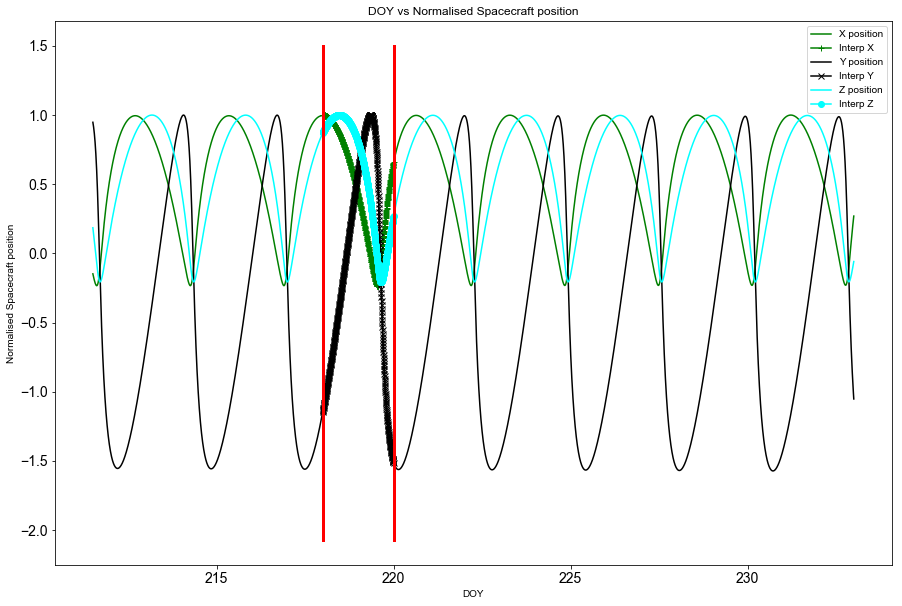

In [7]:
"""Below is a plot of the normalised spacecraft position (x,y,z) vs the DOY to ensure that the interpolated distances lie on the
correct DOY from the emphermis file - denoted by the two vertical red lines"""

fig=plt.figure(figsize=(15, 10))
axes = plt.gca()

axes.set_xlabel('DOY')
axes.set_ylabel('Normalised Spacecraft position')
axes.set_title('DOY vs Normalised Spacecraft position')

axes.plot(doy_sc, orb_x/orb_x.max(), color='green', label = "X position")
axes.plot(eph_doyfrac, orb_x_interp/orb_x_interp.max(), color='green',marker="+",label="Interp X")
axes.plot(doy_sc, orb_y/orb_y.max(), color='black', label = "Y position")
axes.plot(eph_doyfrac, orb_y_interp/orb_y_interp.max(), color='black',marker="x",label="Interp Y")
axes.plot(doy_sc, orb_z/orb_z.max(), color='cyan', label = "Z position")
axes.plot(eph_doyfrac, orb_z_interp/orb_z_interp.max(), color='cyan',marker="o",label="Interp Z")

axes.plot([min(eph_doyfrac),min(eph_doyfrac)], [min(orb_y/orb_y.max())-0.5,1.5], color='red',linestyle='solid', \
         linewidth=3)
axes.plot([max(eph_doyfrac),max(eph_doyfrac)], [min(orb_y/orb_y.max())-0.5,1.5], color='red',linestyle='solid', \
         linewidth=3)
axes.legend()